In [2]:
%%HTML 
<script>
    function luc21893_refresh_cell(cell) {
        if( cell.luc21893 ) return;
        cell.luc21893 = true;
        console.debug('New code cell found...' );
        
        var div = document.createElement('DIV');            
        cell.parentNode.insertBefore( div, cell.nextSibling );
        div.style.textAlign = 'right';
        var a = document.createElement('A');
        div.appendChild(a);
        a.href='#'
        a.luc21893 = cell;
        a.setAttribute( 'onclick', "luc21893_toggle(this); return false;" );

        cell.style.visibility='hidden';
        cell.style.position='absolute';
        a.innerHTML = '[show code]';        
                
    }
    function luc21893_refresh() {                
        if( document.querySelector('.code_cell .input') == null ) {            
            // it apeears that I am in a exported html
            // hide this code
            var codeCells = document.querySelectorAll('.jp-InputArea')
            codeCells[0].style.visibility = 'hidden';
            codeCells[0].style.position = 'absolute';                        
            for( var i = 1; i < codeCells.length; i++ ) {
                luc21893_refresh_cell(codeCells[i].parentNode)
            }
            window.onload = luc21893_refresh;
        }                 
        else {
            // it apperas that I am in a jupyter editor
            var codeCells = document.querySelectorAll('.code_cell .input')
            for( var i = 0; i < codeCells.length; i++ ) {
                luc21893_refresh_cell(codeCells[i])
            }            
            window.setTimeout( luc21893_refresh, 1000 )
        }        
    }
    
    function luc21893_toggle(a) {
        if( a.luc21893.style.visibility=='hidden' ) {
            a.luc21893.style.visibility='visible';        
            a.luc21893.style.position='';
            a.innerHTML = '[hide code]';
        }
        else {
            a.luc21893.style.visibility='hidden';        
            a.luc21893.style.position='absolute';
            a.innerHTML = '[show code]';
        }
    }
    
    luc21893_refresh()
</script>

# <center>Customer Churn Analysis</center>


## Context

The US Wealth Management (USWM) business unit is comprised of Chase Wealth Management, JP Morgan Securities, and the You Invest digital platforms.  Chase Wealth Management (CWM) is a branch-based model in which a dedicated Advisor offers comprehensive financial planning and investment management advice to individuals and families.


## Objective

A key priority for Chase Wealth Management is building and maintaining long-term relationships with CWM clients. The objective is to develop an analytically based strategy **to predict which CWM clients are most likely to churn and how we can stem attrition**.

## Solution

Identifying **the drivers of attrition first** and then develop a **predictive model** with those to predict the customers who are likely to be churned out as well as coming up with **possible recommendations to stem attrition rate (churn rate)**.


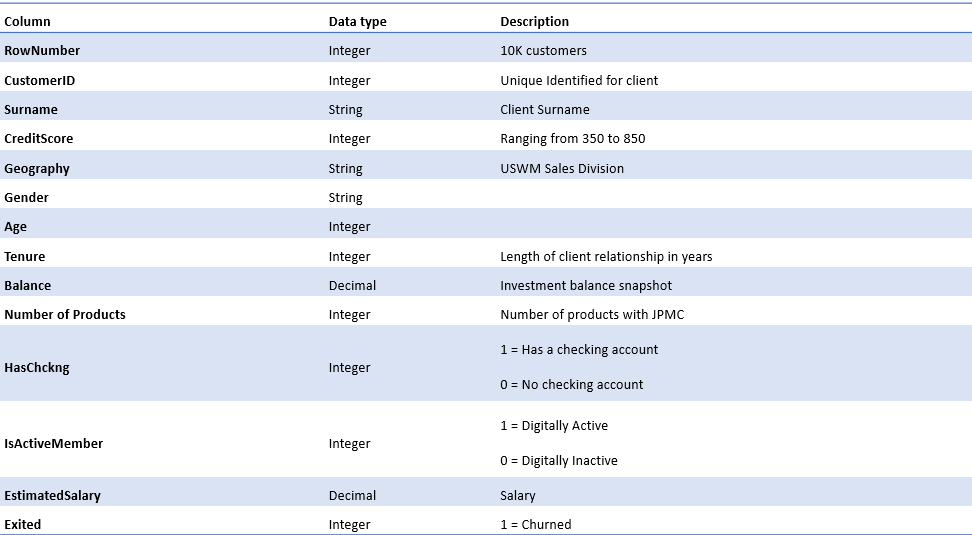

## <center>Installing Required Packages</center>

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib
#matplotlib.use('Agg')

import sklearn
import imblearn

from sklearn.metrics import *
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc

from sklearn.linear_model import LogisticRegression as lor
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

import catboost
from catboost import CatBoostClassifier
import seaborn as sns

from sklearn.model_selection import GridSearchCV


import xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder


from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline


import warnings
warnings.filterwarnings("ignore")

### 1.2 Data Load Steps

In [3]:
path_m = os.getcwd()

In [4]:
def dir_up(path,n):
    for _ in range(n):
        path = dir_up(path.rpartition("\\")[0], 0)
    return(path)

In [5]:
path_d = os.path.join(dir_up(path_m,1),'Data')

In [6]:
df_actual = pd.read_csv(os.path.join(path_d,'Churn Modeling.csv'))

In [7]:
print("A snapshot of the data looks like this - ")
df_actual.head()

A snapshot of the data looks like this - 


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasChckng,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619.0,West,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608.0,Central,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502.0,West,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699.0,West,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850.0,Central,Female,43,2,125510.82,1,1,1,79084.10,0


### 1.3 Creating a new data frame keeping the necessary columns

In [8]:
df_2 = df_actual.drop(['RowNumber','Surname'],axis=1) ## dropping the not necessary columns
print('The variables RowNumber and Surname are dropped from the data\n\n',
      'The total number of customers is {}\n'.format(len(df_2)),
      '{} customers exited the business\n'.format(len(df_2[df_2.Exited ==1])),
      '{} customers are still in the business\n'.format(len(df_2[df_2.Exited == 0])))

The variables RowNumber and Surname are dropped from the data

 The total number of customers is 10000
 2037 customers exited the business
 7963 customers are still in the business



In [9]:
print('Here is a brief on the data we are working on - \n')
df_2.info()

Here is a brief on the data we are working on - 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   CreditScore      9997 non-null   float64
 2   Geography        10000 non-null  object 
 3   Gender           10000 non-null  object 
 4   Age              10000 non-null  int64  
 5   Tenure           10000 non-null  int64  
 6   Balance          10000 non-null  float64
 7   NumOfProducts    10000 non-null  int64  
 8   HasChckng        10000 non-null  int64  
 9   IsActiveMember   10000 non-null  int64  
 10  EstimatedSalary  10000 non-null  float64
 11  Exited           10000 non-null  int64  
dtypes: float64(3), int64(7), object(2)
memory usage: 937.6+ KB


In [10]:
df_2.set_index('CustomerId',inplace=True)

In [11]:
print('Setting the CustomerId column as the index to the dataframe the data looks like -')
df_2.head()

Setting the CustomerId column as the index to the dataframe the data looks like -


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasChckng,IsActiveMember,EstimatedSalary,Exited
CustomerId,,,,,,,,,,,
15634602,619.0,West,Female,42,2,0.00,1,1,1,101348.88,1
15647311,608.0,Central,Female,41,1,83807.86,1,0,1,112542.58,0
15619304,502.0,West,Female,42,8,159660.80,3,1,0,113931.57,1
15701354,699.0,West,Female,39,1,0.00,2,0,0,93826.63,0
15737888,850.0,Central,Female,43,2,125510.82,1,1,1,79084.10,0


## 2. Exploratory Data Analysis

### 2.1  Bivariate Analysis

The plot below compares the mean estimated salary against the dependent variable Exited :-


<AxesSubplot:xlabel='Exited', ylabel='mean est salary'>

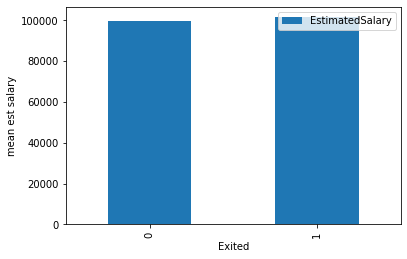

In [12]:
print('The plot below compares the mean estimated salary against the dependent variable Exited :-')

df_actual.pivot_table(values='EstimatedSalary', index=['Exited'], aggfunc='mean').plot.bar(ylabel='mean est salary')

The plot below compares the number of customers who has purchased one,two,three and four products per service against the dependent variable Exited :-


<AxesSubplot:xlabel='Exited', ylabel='No Of Cust'>

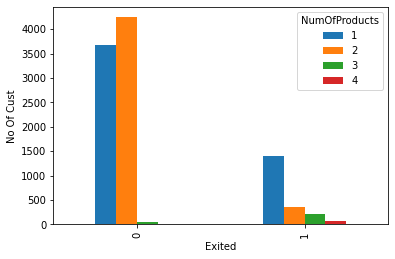

In [13]:
print('The plot below compares the number of customers who has purchased one,two,three and four products per service against the dependent variable Exited :-')

df_actual.pivot_table(values='CustomerId', index=['Exited'],columns = ['NumOfProducts'], aggfunc='count').plot.bar(xlabel='Exited',ylabel='No Of Cust')

The plot below compares the number of customers who has has a checking account vs those who do not have against the dependent variable Exited :-


<AxesSubplot:xlabel='Exited', ylabel='No Of Cust'>

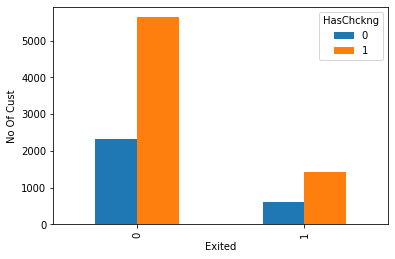

In [14]:
print('The plot below compares the number of customers who has has a checking account vs those who do not have against the dependent variable Exited :-')

df_actual.pivot_table(values='CustomerId', index=['Exited'],columns = ['HasChckng'], aggfunc='count').plot.bar(xlabel='Exited',ylabel='No Of Cust')

The plot below compares the mean credit score against the dependent variable Exited :-


<AxesSubplot:xlabel='Exited', ylabel='mean credit score'>

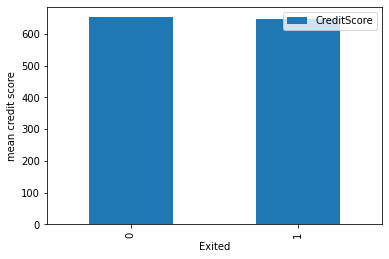

In [15]:
print('The plot below compares the mean credit score against the dependent variable Exited :-')

df_actual.pivot_table(values='CreditScore', index=['Exited'], aggfunc='mean').plot.bar(ylabel='mean credit score')

The plot below compares the Number Of Customers who are Active or Not Active across digital channels against the dependent variable Exited :-


<AxesSubplot:xlabel='Exited', ylabel='No Of Cust'>

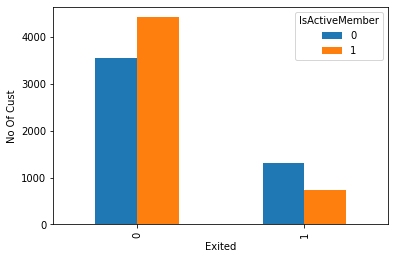

In [16]:
print('The plot below compares the Number Of Customers who are Active or Not Active across digital channels against the dependent variable Exited :-')

df_actual.pivot_table(values='CustomerId', index=['Exited'],columns = ['IsActiveMember'], aggfunc='count').plot.bar(xlabel='Exited',ylabel='No Of Cust')

The plot below compares the Number Of Customers by Gender against the dependent variable Exited :-


<AxesSubplot:xlabel='Exited', ylabel='No Of Cust'>

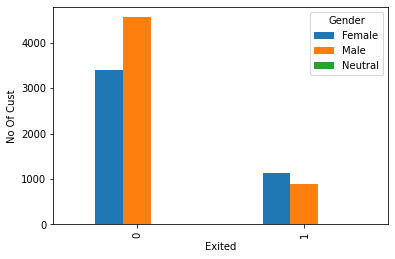

In [17]:
print('The plot below compares the Number Of Customers by Gender against the dependent variable Exited :-')

df_actual.pivot_table(values='CustomerId', index=['Exited'],columns = ['Gender'], aggfunc='count').plot.bar(xlabel='Exited',ylabel='No Of Cust')

The plot below compares the Number Of Customers by Geography against the dependent variable Exited :-


<AxesSubplot:xlabel='Exited', ylabel='No Of Cust'>

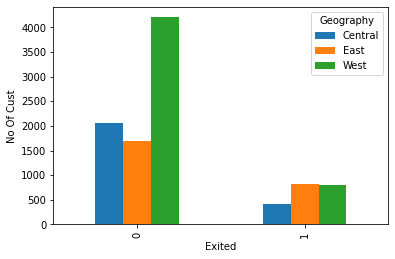

In [18]:
print('The plot below compares the Number Of Customers by Geography against the dependent variable Exited :-')

df_actual.pivot_table(values='CustomerId', index=['Exited'],columns = ['Geography'], aggfunc='count').plot.bar(xlabel='Exited',ylabel='No Of Cust')

The plot below compares the average Balance of customers against the dependent variable Exited :-


<AxesSubplot:xlabel='Exited', ylabel='mean balance'>

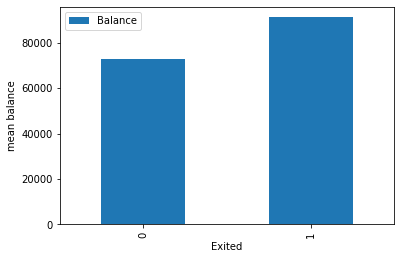

In [19]:
print('The plot below compares the average Balance of customers against the dependent variable Exited :-')

df_actual.pivot_table(values='Balance', index=['Exited'], aggfunc='mean').plot.bar(ylabel='mean balance')

In [20]:
print('The distinct values under Tenure column are as follows :-')

df_actual.Tenure.unique()

The distinct values under Tenure column are as follows :-


array([ 2,  1,  8,  7, 30,  4,  6,  3, 10,  5,  9,  0], dtype=int64)

In [21]:
conditions = [(df_actual['Tenure']<=1), ((df_actual['Tenure']>1) & (df_actual['Tenure']<=5)), (df_actual['Tenure']>5)]
choices = ['0 to 1','1 to 5','Greater than 5']
df_actual['Tenure band'] = np.select(conditions, choices)

The plot below compares the Number Of Customers across Tenure band against the dependent variable Exited :-


<AxesSubplot:xlabel='Exited', ylabel='No Of Cust'>

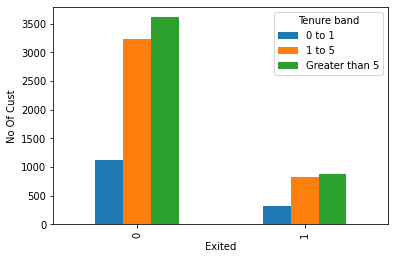

In [22]:
print('The plot below compares the Number Of Customers across Tenure band against the dependent variable Exited :-')

df_actual.pivot_table(values='CustomerId', index=['Exited'],columns = ['Tenure band'], aggfunc='count').plot.bar(xlabel='Exited',ylabel='No Of Cust')

In [23]:
conditions = [(df_actual['Age']<=30), ((df_actual['Age']>30) & (df_actual['Age']<=40)), ((df_actual['Age']>40) & (df_actual['Age']<=50)), (df_actual['Age']>50)]
choices = ['<=30', '30 to 40', '40 to 50', '>50']
df_actual['Age band'] = np.select(conditions, choices)

The plot below compares the Number Of Customers across Age Bands against the dependent variable Exited :-


<AxesSubplot:xlabel='Exited', ylabel='No Of Cust'>

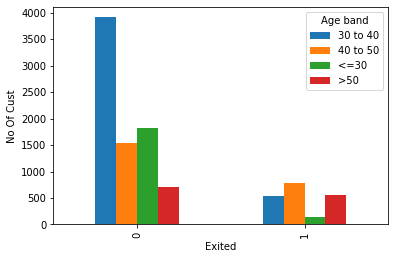

In [24]:
print('The plot below compares the Number Of Customers across Age Bands against the dependent variable Exited :-')

df_actual.pivot_table(values='CustomerId', index=['Exited'],columns = ['Age band'], aggfunc='count').plot.bar(xlabel='Exited',ylabel='No Of Cust')

### 2.2  Multivariate Analysis

The plot below represents the average estimated salary of non exited customers against different age band :-


<AxesSubplot:xlabel='Age band', ylabel='mean est salary'>

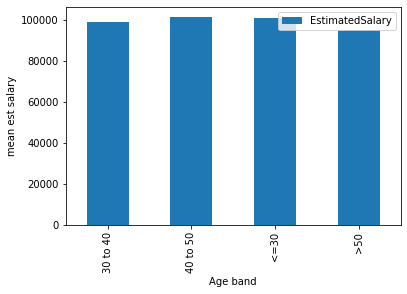

In [25]:
print('The plot below represents the average estimated salary of non exited customers against different age band :-')

df_actual[df_actual['Exited']==0].pivot_table(values='EstimatedSalary', index=['Age band'], aggfunc='mean').plot.bar(ylabel='mean est salary')

The plot below represents the average estimated salary of the Exited customers against different age band :-


<AxesSubplot:xlabel='Age band', ylabel='mean est salary'>

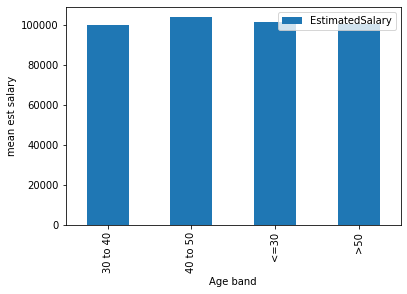

In [26]:
print('The plot below represents the average estimated salary of the Exited customers against different age band :-')

df_actual[df_actual['Exited']==1].pivot_table(values='EstimatedSalary', index=['Age band'], aggfunc='mean').plot.bar(ylabel='mean est salary')

The plot below represents the average balance of the Exited customers against different age band :-


<AxesSubplot:xlabel='Age band', ylabel='mean balance'>

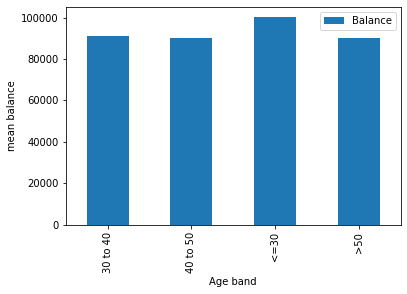

In [27]:
print('The plot below represents the average balance of the Exited customers against different age band :-')

df_actual[df_actual['Exited']==1].pivot_table(values='Balance', index=['Age band'], aggfunc='mean').plot.bar(ylabel='mean balance')

The plot below represents the average balance of the Non Exited customers against different age band :-


<AxesSubplot:xlabel='Age band', ylabel='mean balance'>

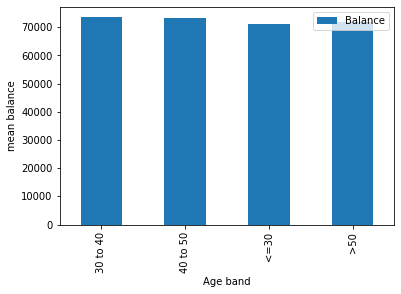

In [28]:
print('The plot below represents the average balance of the Non Exited customers against different age band :-')

df_actual[df_actual['Exited']==0].pivot_table(values='Balance', index=['Age band'], aggfunc='mean').plot.bar(ylabel='mean balance')

The plot below represents the number of Exited customers across purchase of number of products per service against different age band :-


<AxesSubplot:xlabel='Age band', ylabel='No Of Cust'>

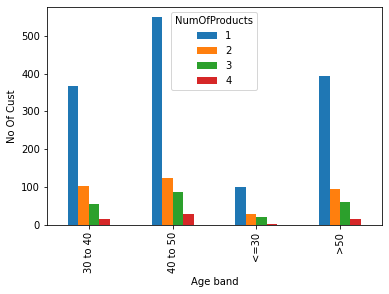

In [29]:
print('The plot below represents the number of Exited customers across purchase of number of products per service against different age band :-')

df_actual[df_actual['Exited']==1].pivot_table(values='CustomerId', index=['Age band'],columns = ['NumOfProducts'], aggfunc='count').plot.bar(xlabel='Age band',ylabel='No Of Cust')

The plot below represents the number of Non Exited customers across purchase of number of products per service against different age band :-


<AxesSubplot:xlabel='Age band', ylabel='No Of Cust'>

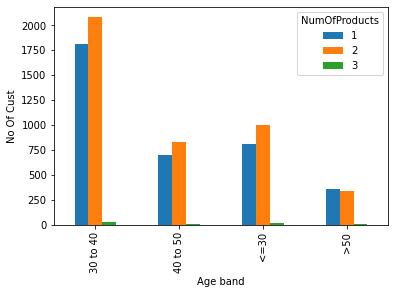

In [30]:
print('The plot below represents the number of Non Exited customers across purchase of number of products per service against different age band :-')

df_actual[df_actual['Exited']==0].pivot_table(values='CustomerId', index=['Age band'],columns = ['NumOfProducts'], aggfunc='count').plot.bar(xlabel='Age band',ylabel='No Of Cust')

The plot below represents the number of Exited customers with respect to being Active or Not Active in digital channels against different age band :-


<AxesSubplot:xlabel='Age band', ylabel='No Of Cust'>

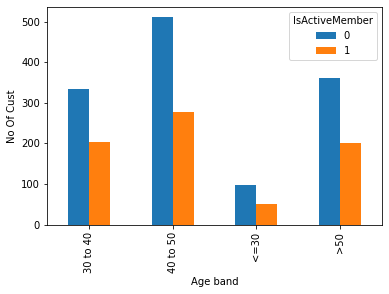

In [31]:
print('The plot below represents the number of Exited customers with respect to being Active or Not Active in digital channels against different age band :-')

df_actual[df_actual['Exited']==1].pivot_table(values='CustomerId', index=['Age band'],columns = ['IsActiveMember'], aggfunc='count').plot.bar(xlabel='Age band',ylabel='No Of Cust')

The plot below represents the number of Non Exited customers with respect to being Active or Not Active in digital channels against different age band :-


<AxesSubplot:xlabel='Age band', ylabel='No Of Cust'>

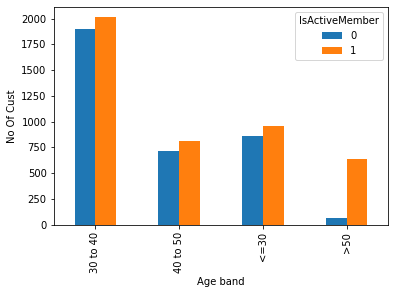

In [32]:
print('The plot below represents the number of Non Exited customers with respect to being Active or Not Active in digital channels against different age band :-')

df_actual[df_actual['Exited']==0].pivot_table(values='CustomerId', index=['Age band'],columns = ['IsActiveMember'], aggfunc='count').plot.bar(xlabel='Age band',ylabel='No Of Cust')

The plot below represents the number of Exited customers across Tenure band against different age band :-


<AxesSubplot:xlabel='Age band', ylabel='No Of Cust'>

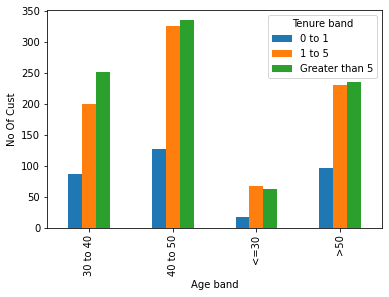

In [33]:
print('The plot below represents the number of Exited customers across Tenure band against different age band :-')

df_actual[df_actual['Exited']==1].pivot_table(values='CustomerId', index=['Age band'],columns = ['Tenure band'], aggfunc='count').plot.bar(xlabel='Age band',ylabel='No Of Cust')

The plot below represents the number of Non Exited customers across Tenure band against different age band :-


<AxesSubplot:xlabel='Age band', ylabel='No Of Cust'>

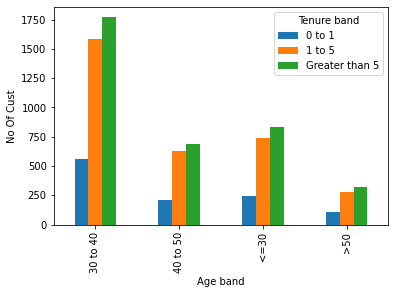

In [34]:
print('The plot below represents the number of Non Exited customers across Tenure band against different age band :-')

df_actual[df_actual['Exited']==0].pivot_table(values='CustomerId', index=['Age band'],columns = ['Tenure band'], aggfunc='count').plot.bar(xlabel='Age band',ylabel='No Of Cust')

The plot below represents the number of Exited customers across Geography against different age band :-


<AxesSubplot:xlabel='Age band', ylabel='No Of Cust'>

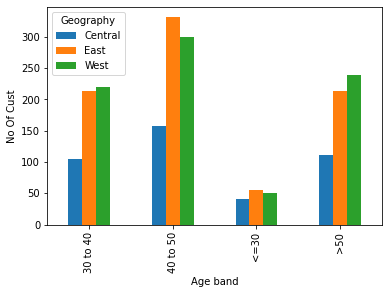

In [35]:
print('The plot below represents the number of Exited customers across Geography against different age band :-')

df_actual[df_actual['Exited']==1].pivot_table(values='CustomerId', index=['Age band'],columns = ['Geography'], aggfunc='count').plot.bar(xlabel='Age band',ylabel='No Of Cust')

The plot below represents the number of Non Exited customers across Geography against different age band :-


<AxesSubplot:xlabel='Age band', ylabel='No Of Cust'>

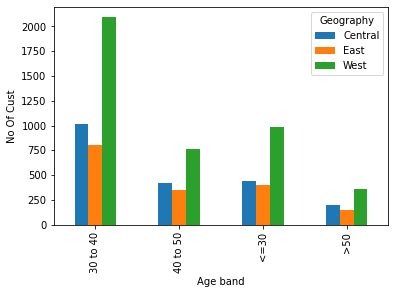

In [36]:
print('The plot below represents the number of Non Exited customers across Geography against different age band :-')

df_actual[df_actual['Exited']==0].pivot_table(values='CustomerId', index=['Age band'],columns = ['Geography'], aggfunc='count').plot.bar(xlabel='Age band',ylabel='No Of Cust')

### 2.3 Univariate Analysis for Categorical Variables

In [37]:
print('The frequency distribution of total customers by Activity across digital channels :-')

df_actual.IsActiveMember.value_counts()

The frequency distribution of total customers by Activity across digital channels :-


1    5151
0    4849
Name: IsActiveMember, dtype: int64

In [38]:
print('The frequency distribution of total customers by Activity across digital channels :-')

df_actual.HasChckng.value_counts()

The frequency distribution of total customers by Activity across digital channels :-


1    7055
0    2945
Name: HasChckng, dtype: int64

In [39]:
print('The frequency distribution of total customers by Activity across Geography :-')

df_actual.Geography.value_counts()

The frequency distribution of total customers by Activity across Geography :-


West       5014
East       2509
Central    2477
Name: Geography, dtype: int64

In [40]:
print('The frequency distribution of total customers by Activity across Gender :-')

df_actual.Gender.value_counts()

The frequency distribution of total customers by Activity across Gender :-


Male       5453
Female     4539
Neutral       8
Name: Gender, dtype: int64

In [41]:
print('The relative frequency distribution of total customers across Exited and Non Exited customer against Activity across digital channels :-')

pd.crosstab(df_actual.IsActiveMember,df_actual.Exited,normalize='index')

The relative frequency distribution of total customers across Exited and Non Exited customer against Activity across digital channels :-


Exited,0,1
IsActiveMember,,
0,0.731491,0.268509
1,0.857309,0.142691


In [42]:
print('The relative frequency distribution of total customers across Exited and Non Exited customer against having a Checking Account or not :-')

pd.crosstab(df_actual.HasChckng,df_actual.Exited,normalize='index')

The relative frequency distribution of total customers across Exited and Non Exited customer against having a Checking Account or not :-


Exited,0,1
HasChckng,,
0,0.791851,0.208149
1,0.798157,0.201843


In [43]:
print('The relative frequency distribution of total customers across Exited and Non Exited customer against different Geography :-')

pd.crosstab(df_actual.Geography,df_actual.Exited,normalize='index')

The relative frequency distribution of total customers across Exited and Non Exited customer against different Geography :-


Exited,0,1
Geography,,
Central,0.833266,0.166734
East,0.675568,0.324432
West,0.838452,0.161548


In [44]:
print('The relative frequency distribution of total customers across Exited and Non Exited customer against different Genders :-')

pd.crosstab(df_actual.Gender,df_actual.Exited,normalize='index')

The relative frequency distribution of total customers across Exited and Non Exited customer against different Genders :-


Exited,0,1
Gender,,
Female,0.749504,0.250496
Male,0.835687,0.164313
Neutral,0.500000,0.500000


### 2.4  Univariate Analysis for Numerical Variables ,Outlier Detection and Missing Value Treatment

In [45]:
num_list = ['Age','Tenure','CreditScore', 'Balance', 'EstimatedSalary','NumOfProducts']

def outlier_detection(df,num_list,exited):
    df_percentiles = pd.DataFrame()
    for i in num_list:
        df_percentiles = pd.concat([df[df.Exited==exited][i].describe([0.01,0.05,.1, .2, .3, .4, .5, .6,.7,.8,.9,.95,.99,1]).reset_index().T[0:] for i in num_list])
        df_percentiles = df_percentiles.reset_index().drop_duplicates()
        df_percentiles.columns = df_percentiles.iloc[0]
        df_percentiles = df_percentiles.iloc[1:]
        return df_percentiles

In [46]:
def outlier_detection_all(df,num_list):
    df_percentiles = pd.DataFrame()
    for i in num_list:
        df_percentiles = pd.concat([df[i].describe([0.01,0.05,.1, .2, .3, .4, .5, .6,.7,.8,.9,.95,.99,1]).reset_index().T[0:] for i in num_list])
        df_percentiles = df_percentiles.reset_index().drop_duplicates()
        df_percentiles.columns = df_percentiles.iloc[0]
        df_percentiles = df_percentiles.iloc[1:]
        return df_percentiles

In [47]:
print('Considering all customers, for numerical variables, the data distribution across percentiles look like this :\n')

outlier_detection_all  = outlier_detection_all(df_actual,num_list)
outlier_detection_all
#outlier_detection_all.to_excel(os.path.join(dir_up(path_m,1),'Model','summary_all.xlsx'))

Considering all customers, for numerical variables, the data distribution across percentiles look like this :



,index,count,mean,std,min,1%,5%,10%,20%,30%,40%,50%,60%,70%,80%,90%,95%,99%,100%,max
1,Age,10000.0,38.9435,10.613726,18.0,21.0,25.0,27.0,31.0,33.0,35.0,37.0,40.0,42.0,46.0,53.0,60.0,72.0,190.0,190.0
3,Tenure,10000.0,5.0154,2.902931,0.0,0.0,1.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,9.0,10.0,30.0,30.0
5,CreditScore,9997.0,650.496849,96.7086,305.0,431.96,489.0,521.0,566.0,598.0,627.0,652.0,678.0,704.0,735.0,778.0,812.0,850.0,865.0,865.0
7,Balance,10000.0,76485.889288,62397.405202,0.0,0.0,0.0,0.0,0.0,0.0,73080.908,97198.54,110138.926,122029.87,133710.358,149244.792,162711.669,185967.9854,250898.09,250898.09
9,EstimatedSalary,10000.0,100090.239881,57510.492818,11.58,1842.8253,9851.8185,20273.58,41050.736,60736.079,80238.34,100193.915,119710.038,139432.236,159836.726,179674.704,190155.3755,198069.7345,199992.48,199992.48
11,NumOfProducts,10000.0,1.5302,0.581654,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,3.0,4.0,4.0


In [48]:
print('Considering exited customers, for numerical variables, the data distribution across percentiles look like this :\n')

outlier_detection_exited  = outlier_detection(df_actual,num_list,1)
outlier_detection_exited
#outlier_detection_exited.to_excel(os.path.join(dir_up(path_m,1),'Model','summary_exited.xlsx'))

Considering exited customers, for numerical variables, the data distribution across percentiles look like this :



,index,count,mean,std,min,1%,5%,10%,20%,30%,40%,50%,60%,70%,80%,90%,95%,99%,100%,max
1,Age,2037.0,44.837997,9.761562,18.0,23.0,29.0,32.0,37.0,40.0,42.0,45.0,47.0,50.0,53.0,58.0,61.0,68.0,84.0,84.0
3,Tenure,2037.0,4.945508,2.988103,0.0,0.0,1.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,9.2,10.0,30.0,30.0
5,CreditScore,2037.0,645.183603,100.604522,305.0,402.08,478.8,517.0,557.0,593.0,620.0,646.0,672.0,703.0,735.0,776.4,812.2,850.0,850.0,850.0
7,Balance,2037.0,91108.539337,58360.794816,0.0,0.0,0.0,0.0,0.0,76717.528,99339.732,109349.29,118094.244,127093.772,136896.154,152080.618,167698.24,197355.2884,250898.09,250898.09
9,EstimatedSalary,2037.0,101465.677531,57912.418071,11.58,2165.8736,10030.76,20539.95,41793.644,61814.88,82279.322,102460.84,121519.426,141983.924,162688.39,180169.39,190328.982,197717.2976,199808.1,199808.1
11,NumOfProducts,2037.0,1.475209,0.801521,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,3.0,3.0,4.0,4.0,4.0


In [49]:
print('Considering non-exited customers, for numerical variables, the data distribution across percentiles look like this :\n')

outlier_detection_nonexited = outlier_detection(df_actual,num_list,0)
outlier_detection_nonexited
#outlier_detection_nonexited.to_excel(os.path.join(dir_up(path_m,1),'Model','summary_nonexited.xlsx'))

Considering non-exited customers, for numerical variables, the data distribution across percentiles look like this :



,index,count,mean,std,min,1%,5%,10%,20%,30%,40%,50%,60%,70%,80%,90%,95%,99%,100%,max
1,Age,7963.0,37.43564,10.292823,18.0,20.0,24.0,27.0,30.0,32.0,34.0,36.0,38.0,40.0,43.0,49.0,59.0,73.0,190.0,190.0
3,Tenure,7963.0,5.033279,2.880658,0.0,0.0,1.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,9.0,10.0,10.0,10.0
5,CreditScore,7960.0,651.856533,95.64522,405.0,438.0,492.0,523.0,568.0,600.0,628.0,653.0,679.0,704.0,734.2,778.0,812.0,850.0,865.0,865.0
7,Balance,7963.0,72745.296779,62848.040701,0.0,0.0,0.0,0.0,0.0,0.0,54422.476,92072.68,106959.26,120537.794,132852.782,148730.298,161592.595,183753.9062,221532.8,221532.8
9,EstimatedSalary,7963.0,99738.391772,57405.586966,90.07,1799.5508,9773.542,20140.15,40701.002,60413.228,79918.36,99645.04,119248.612,138530.972,159411.42,179453.212,190107.557,198131.4652,199992.48,199992.48
11,NumOfProducts,7963.0,1.544267,0.509536,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,3.0


In [50]:
print('In overall data the percentage of customers who exited the business are :', len(df_2[df_2['Exited']==1])/len(df_2)*100)
print('In overall data the percentage of customers who stayed in the business are :', len(df_2[df_2['Exited']==0])/len(df_2)*100)
print('Therefore the data is imbalanced')

In overall data the percentage of customers who exited the business are : 20.369999999999997
In overall data the percentage of customers who stayed in the business are : 79.63
Therefore the data is imbalanced


## 3.  Feature Engineering

In [51]:
print('The number of missing values across columns in the data initially is:\n')

df_2.isna().sum()

The number of missing values across columns in the data initially is:



CreditScore        3
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasChckng          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

Replacing the three missing **credit scores** by the mean of the distribution .
Replacing the **Age of a customer** by the 99th percentile value, who by records is of age 190 which looks as an outlier

In [52]:
mean_credit_sc=df_2['CreditScore'].mean()

df_2['CreditScore'].fillna(value=mean_credit_sc, inplace=True) 

In [53]:
df_2.loc[(df_2.Age==190),'Age'] = df_2.Age.quantile(0.99)

In [54]:
print('The number of missing values across columns in the data now:\n')

df_2.isna().sum()

The number of missing values across columns in the data now:



CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasChckng          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

#### Therefore, the data is free from any missing values and outliers.

We need to group certain variables such as **Credit Score** , **Age** and **Estimated Salary** due since they have **high degree of variation**. Also,the variable **Balance** consists of large number of 0's due to which the modelling distribution might become biased towards one side. 

### 3.1  Variable Creation Step

In [55]:
## Defining the function to get the classes for respective feature

def cutoff(df,col):
    return pd.qcut(df[col],6).value_counts()

In [56]:
print('The class frequency distribution table for the variable CreditScore is as follows:\n')

cutoff(df_2,'CreditScore')

The class frequency distribution table for the variable CreditScore is as follows:



(304.999, 553.0]    1683
(553.0, 608.0]      1680
(608.0, 652.0]      1673
(652.0, 695.0]      1662
(748.0, 865.0]      1652
(695.0, 748.0]      1650
Name: CreditScore, dtype: int64

In [57]:
print('The class frequency distribution table for the variable Age is as follows:\n')

cutoff(df_2,'Age')

The class frequency distribution table for the variable Age is as follows:



(17.999, 30.0]    1967
(30.0, 34.0]      1711
(37.0, 41.0]      1698
(41.0, 48.0]      1672
(48.0, 101.0]     1544
(34.0, 37.0]      1408
Name: Age, dtype: int64

In [58]:
print('The class frequency distribution table for the variable EstimatedSalary is as follows:\n')

cutoff(df_2,'EstimatedSalary')

The class frequency distribution table for the variable EstimatedSalary is as follows:



(11.579, 34025.025]        1667
(34025.025, 67057.27]      1667
(100193.915, 132801.57]    1667
(166912.72, 199992.48]     1667
(67057.27, 100193.915]     1666
(132801.57, 166912.72]     1666
Name: EstimatedSalary, dtype: int64

In [59]:
print('The class frequency distribution table for the variable Balance is as follows:\n')

pd.qcut(df_2['Balance'],6,duplicates ='drop').value_counts()

The class frequency distribution table for the variable Balance is as follows:



(-0.001, 97198.54]        5000
(97198.54, 118100.59]     1667
(138294.79, 250898.09]    1667
(118100.59, 138294.79]    1666
Name: Balance, dtype: int64

In [60]:
#pd.qcut(df_2['Tenure'],6,duplicates ='drop').value_counts()

In [61]:
df_2['Credit_sc_band'] = pd.qcut(df_2['CreditScore'],6,labels=['crsc_553', 'crsc_553_608', 'crsc_608_652', 'crsc_652_695', 'crsc_695_to_748', 'crsc_748_to_865'])
df_2['Age_band'] = pd.qcut(df_2['Age'],6,labels=['age_30', 'age_30_34', 'age_34_37', 'age_37_41', 'age_41_48', 'age_greater_48'])
df_2['Est_salary_band'] = pd.qcut(df_2['EstimatedSalary'],6,labels=['esal_34025', 'esal_34025_67057', 'esal_67057_100194', 'esal_100194_132801', 'esal_132801_166913', 'esal_greater_166913'])
df_2['Balance_band'] = pd.qcut(df_2['Balance'],6,labels=['bal_97198', 'bal_97198_118100', 'bal_118100_138294', 'bal_greater_138294'],duplicates='drop')
#df_2['Tenure_band'] = pd.qcut(df_2['Tenure'],6,labels=['ten_2', 'ten_2_3', 'ten_3_5', 'ten_5_7', 'ten_7_8', 'ten_greater_8'],duplicates='drop')

In [62]:
df_2.drop(['CreditScore', 'Age', 'Balance', 'EstimatedSalary'], axis=1, inplace=True)

Created a list of categorical features from the variables **CreditScore, Age, EstimatedSalary** and **Balance** and now the new data looks like this :-

In [63]:
df_2.head()

,Geography,Gender,Tenure,NumOfProducts,HasChckng,IsActiveMember,Exited,Credit_sc_band,Age_band,Est_salary_band,Balance_band
CustomerId,,,,,,,,,,,
15634602,West,Female,2,1,1,1,1,crsc_608_652,age_41_48,esal_100194_132801,bal_97198
15647311,Central,Female,1,1,0,1,0,crsc_553_608,age_37_41,esal_100194_132801,bal_97198
15619304,West,Female,8,3,1,0,1,crsc_553,age_41_48,esal_100194_132801,bal_greater_138294
15701354,West,Female,1,2,0,0,0,crsc_695_to_748,age_37_41,esal_67057_100194,bal_97198
15737888,Central,Female,2,1,1,1,0,crsc_748_to_865,age_41_48,esal_67057_100194,bal_118100_138294


### 3.2  WOE and IV value calculation

Below we can see the WOE and IV values calculated against the different classes for each of the variables : **Geography, Gender, Tenure, NumOfProducts, HasChckng, IsActiveMember, Credit_sc_band, Age_band, Est_salary_band** and **Balance_band**

In [64]:
def calculate_woe_iv(df, pred, target):
    lst = []
    for i in range(df[pred].nunique()):
        v = list(df[pred].unique())[i]
        lst.append({
            'Value': v,
            'All': df[df[pred] == v].count()[pred],
            'Good': df[(df[pred] == v) & (df[target] == 0)].count()[pred],
            'Bad': df[(df[pred] == v) & (df[target] == 1)].count()[pred]
        })
        
    dfn = pd.DataFrame(lst)
    dfn['Distr_Good'] = dfn['Good'] / dfn['Good'].sum()
    dfn['Distr_Bad'] = dfn['Bad'] / dfn['Bad'].sum()
    dfn['WoE'] = np.log(dfn['Distr_Good'] / dfn['Distr_Bad'])
    dfn = dfn.replace({'WoE': {np.inf: 0, -np.inf: 0}})
    dfn['IV'] = (dfn['Distr_Good'] - dfn['Distr_Bad']) * dfn['WoE']
    iv = dfn['IV'].sum()
    
    dfn = dfn.sort_values(by='WoE')
    
    return dfn, iv

In [65]:
for col in df_2.columns:
    if col == 'Exited': continue
    else:
        print('WoE and IV for column: {}'.format(col))
        df_woe_iv, iv = calculate_woe_iv(df_2, col, 'Exited')
        print(df_woe_iv)
        print('IV score: {:.2f}'.format(iv))
        print('\n')

WoE and IV for column: Geography
     Value   All  Good  Bad  Distr_Good  Distr_Bad       WoE        IV
2     East  2509  1695  814    0.212859   0.399607 -0.629850  0.117623
1  Central  2477  2064  413    0.259199   0.202749  0.245626  0.013865
0     West  5014  4204  810    0.527942   0.397644  0.283430  0.036930
IV score: 0.17


WoE and IV for column: Gender
     Value   All  Good   Bad  Distr_Good  Distr_Bad       WoE        IV
2  Neutral     8     4     4    0.000502   0.001964 -1.363328  0.001992
0   Female  4539  3402  1137    0.427226   0.558174 -0.267357  0.035010
1     Male  5453  4557   896    0.572272   0.439863  0.263152  0.034844
IV score: 0.07


WoE and IV for column: Tenure
    Value   All  Good  Bad  Distr_Good  Distr_Bad       WoE        IV
11      0   413   318   95    0.039935   0.046637 -0.155153  0.001040
1       1  1035   803  232    0.100841   0.113893 -0.121710  0.001589
10      9   984   771  213    0.096823   0.104566 -0.076931  0.000596
7       3  1009   796

As we can see from above , that, the variable 'NumOfProducts' has the highest IV of **0.8** , followed by 'Age_band' which is **0.75**, followed by 'Geography' which is **0.17**, followed by 'IsActiveMember' which is **0.15** , followed by 'Balance_band' which is **0.09**, followed by 'Gender' which is **0.07** , followed by 'Tenure' which is **0.01** , followed by 'Credit_sc_band' which is **0.01** and finally followed by 'Est_Salary_band' which is **0.00** and 'HasChckng' which is **0.00**

| Variables | Information Value | Predictive Power |
| :- | -: | :-: |
| NumOfProducts | 0.8 | Suspicious or too good to be true (>0.5)
| Age_band | 0.75 | Suspicious or too good to be true (>0.5)
| Geography | 0.17 | Medium Predictor (0.1 to 0.3)
| IsActiveMember | 0.15 | Medium Predictor (0.1 to 0.3)
| Balance_band | 0.09 | Weak Predictor (0.02 to 0.1)
| Gender | 0.07 | Weak Predictor (0.02 to 0.1)
| Tenure | 0.01 | Useless for Prediction (<0.02)
| Credit_sc_band | 0.01 | Useless for Prediction (<0.02)
| Est_Salary_band | 0.00 | Useless for Prediction (<0.02)
| HasChckng | 0.00 | Useless for Prediction (<0.02)

As we can see below, that the variable **"Geography"** is a medium predictor. Two of it's classes Central(**0.245626**) and West(**0.283430**) have very close value of WOE. Therefore, we need to apply **coarsing** on this variable.

In [66]:
df_geography, iv_geography = calculate_woe_iv(df_2,'Geography','Exited')
df_geography

,Value,All,Good,Bad,Distr_Good,Distr_Bad,WoE,IV
2,East,2509,1695,814,0.212859,0.399607,-0.629850,0.117623
1,Central,2477,2064,413,0.259199,0.202749,0.245626,0.013865
0,West,5014,4204,810,0.527942,0.397644,0.283430,0.036930


In [67]:
def coarsing(df, i1, i2):
    mean_col = pd.DataFrame(np.mean(pd.DataFrame([df.iloc[i1], df.iloc[i2]]))).T
    actual = df.drop([i1, i2])
    
    coarse_df = pd.concat([actual, mean_col])
    coarse_df = coarse_df.sort_values(by='WoE', ascending=False).reset_index(drop=True)
    
    return coarse_df

Therefore, post coarsing the **WOE and IV** table for the variable **Geography** is as follows:-

In [68]:
df_geography = coarsing(df_geography, 1,0)
df_geography

,Value,All,Good,Bad,Distr_Good,Distr_Bad,WoE,IV
0,NaN,2493.0,1879.5,613.5,0.236029,0.301178,-0.192112,0.065744
1,East,2509.0,1695.0,814.0,0.212859,0.399607,-0.629850,0.117623


In [69]:
df_2['Geography'].replace({ 'West': 'West_and_Central', 'Central': 'West_and_Central' }, inplace=True)

Post Coarsing the final **WOE and IV** values for the variables are as follows:-

In [70]:
for col in df_2.columns:
    if col == 'Exited': continue
    else:
        print('WoE and IV for column: {}'.format(col))
        df_woe_iv, iv = calculate_woe_iv(df_2, col, 'Exited')
        print(df_woe_iv)
        print('IV score: {:.2f}'.format(iv))
        print('\n')

WoE and IV for column: Geography
              Value   All  Good   Bad  Distr_Good  Distr_Bad       WoE  \
1              East  2509  1695   814    0.212859   0.399607 -0.629850   
0  West_and_Central  7491  6268  1223    0.787141   0.600393  0.270823   

         IV  
1  0.117623  
0  0.050576  
IV score: 0.17


WoE and IV for column: Gender
     Value   All  Good   Bad  Distr_Good  Distr_Bad       WoE        IV
2  Neutral     8     4     4    0.000502   0.001964 -1.363328  0.001992
0   Female  4539  3402  1137    0.427226   0.558174 -0.267357  0.035010
1     Male  5453  4557   896    0.572272   0.439863  0.263152  0.034844
IV score: 0.07


WoE and IV for column: Tenure
    Value   All  Good  Bad  Distr_Good  Distr_Bad       WoE        IV
11      0   413   318   95    0.039935   0.046637 -0.155153  0.001040
1       1  1035   803  232    0.100841   0.113893 -0.121710  0.001589
10      9   984   771  213    0.096823   0.104566 -0.076931  0.000596
7       3  1009   796  213    0.099962  

With respect to IV values , the significant variables are **NumberOfProducts**, **Age_band**, **Geography** and **IsActiveMember** in descending order of IV values

As we can see **IsActiveMember** is already a binary variable , whereas NumberOfProducts, Age_band, Geography and IsActiveMember are not. Therefore, dummy variables need to be created for the same.

### 3.3  Creating dummy variables

In [71]:
geography_dummy = pd.get_dummies(df_2['Geography'], drop_first=False, prefix='Geography')
num_of_products_dummy = pd.get_dummies(df_2['NumOfProducts'], drop_first=False, prefix='Num_Prods')
age_dummy = pd.get_dummies(df_2['Age_band'], drop_first=False)

print('The dummy variables are created for the variables Geography, NumOfProducts and Age_band')

The dummy variables are created for the variables Geography, NumOfProducts and Age_band


### 3.4  Creating the dataframe for Model Development

In [72]:
df_2 = pd.concat([geography_dummy, num_of_products_dummy, age_dummy, df_2[['IsActiveMember', 'Exited']]], axis=1)

print('The dataframe along with dummy variables look like:\n')
df_2.head()

The dataframe along with dummy variables look like:



,Geography_East,Geography_West_and_Central,Num_Prods_1,Num_Prods_2,Num_Prods_3,Num_Prods_4,age_30,age_30_34,age_34_37,age_37_41,age_41_48,age_greater_48,IsActiveMember,Exited
CustomerId,,,,,,,,,,,,,,
15634602,0,1,1,0,0,0,0,0,0,0,1,0,1,1
15647311,0,1,1,0,0,0,0,0,0,1,0,0,1,0
15619304,0,1,0,0,1,0,0,0,0,0,1,0,0,1
15701354,0,1,0,1,0,0,0,0,0,1,0,0,0,0
15737888,0,1,1,0,0,0,0,0,0,0,1,0,1,0


In order to check the associations between the categorical variables, we need to find how each of them are connected to the other by means of **Cramer's V** formula. A high value towards +-1 indicates very strong relation and a value closer towards 0 represents the variables are independent of one another.

### 3.5  Association Matrix by Cramer's V formula

In [73]:
from dython.nominal import associations

In [74]:
X = df_2.iloc[:,:-1]

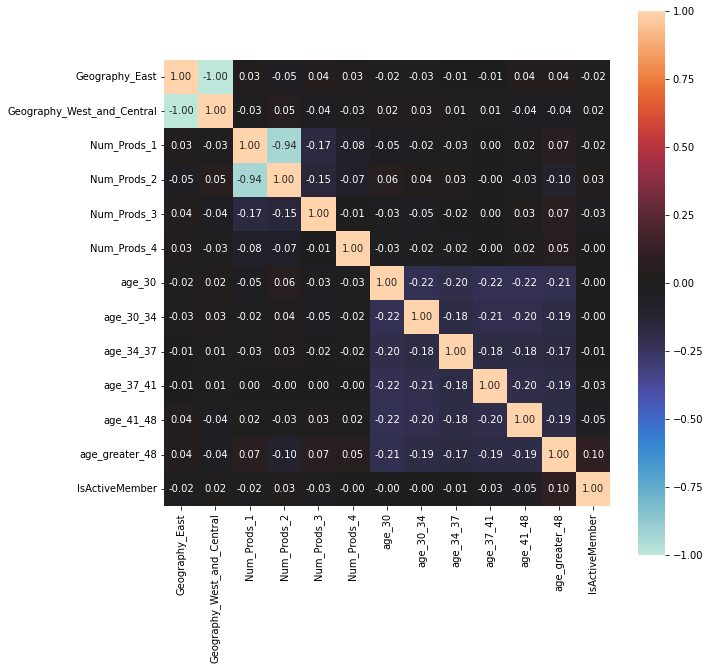

In [75]:
categorical_correlation= associations(X, filename= 'categorical_correlation.png', figsize=(10,10))

As, we can see from above correlation chart says(by Cramer's V values) that variables **Num_Prods_1** and **Num_Prods_2** are closely associated but we will proceed with **Num_Prods_2** only as it has more information value(**0.411545**)  than the former(**0.093149**).

Therefore, for model development we are proceeding with the following set of features: *Geography_East, Num_Prods_1, Num_Prods_2, Num_Prods_3, Num_Prods_4, age_30, age_30_34, age_34_37, age_37_41, age_41_48, age_greater_48, IsActiveMember*.

In [76]:
X = X.drop(columns = ['Num_Prods_1','Geography_West_and_Central'])

In [77]:
Y = df_2.iloc[:,df_2.shape[1]-1:df_2.shape[1]]

## 4.  Model Development Module

### 4.1  Train Test Split

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3,random_state = 42)
print ('In training data, X variables contain {} rows and columns respectively and Y variable contain {} rows and columns respectively '.format(X_train.shape, y_train.shape))
print ('In test data, X variables contain {} rows and columns respectively and Y variable contain {} rows and columns respectively '.format(X_test.shape, y_test.shape))


print('In training data the percentage of customers who exited the business are :', len(y_train[y_train['Exited']==1])/len(y_train)*100)
print('In training data the percentage of customers who stayed in the business are :', len(y_train[y_train['Exited']==0])/len(y_train)*100)
print('In test data the percentage of customers who exited the business are :', len(y_test[y_test['Exited']==1])/len(y_test)*100)
print('In test data the percentage of customers who stayed in the business are :', len(y_test[y_test['Exited']==0])/len(y_test)*100)
print('Therefore the training data is imbalanced')
#print (X_test.shape, y_test.shape)

In training data, X variables contain (7000, 11) rows and columns respectively and Y variable contain (7000, 1) rows and columns respectively 
In test data, X variables contain (3000, 11) rows and columns respectively and Y variable contain (3000, 1) rows and columns respectively 
In training data the percentage of customers who exited the business are : 20.757142857142856
In training data the percentage of customers who stayed in the business are : 79.24285714285715
In test data the percentage of customers who exited the business are : 19.466666666666665
In test data the percentage of customers who stayed in the business are : 80.53333333333333
Therefore the training data is imbalanced


The entire data set has been splitted into **train** and **test** set taking **70% as train data** and remaining **30% as test data**

In [79]:
print('The number of rows in training data is:\n')
len(y_train)

The number of rows in training data is:



7000

In [80]:
print('The number of rows in test data is:\n')
len(y_test)

The number of rows in test data is:



3000

### 4.2  LOGISTIC REGRESSION MODEL

### 4.2.1  Let us first try to build a model with the unbalanced dataset first

In [81]:
classifier = lor()

In [82]:
model = classifier.fit(X_train,y_train)
print('Accuracy on train set containing unbalanced data : {:.2f}%'.format(classifier.score(X_train, y_train)*100))

Accuracy on train set containing unbalanced data : 84.96%


### 4.2.2  Model Performance on Test Set

In [83]:
predictions = classifier.predict(X_test)
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy on test set : %.2f%%" % (accuracy * 100.0))

Accuracy on test set : 86.10%


### 4.2.3  Confusion Matrix for Logistic Regression Model (with unbalanced data)

In [84]:
# confusion matrix in sklearn

# actual values
actual = y_test.values.tolist()
# predicted values
predicted = predictions.tolist()

# confusion matrix
con_matrix = confusion_matrix(actual,predicted, labels=[0,1])
print('Confusion matrix : \n',con_matrix)

# outcome values order in sklearn
tp, fn, fp, tn = confusion_matrix(actual,predicted,labels=[1,0]).reshape(-1)
print("\nTPR or Sensitivity or Recall is {:.2f}".format(tp/(tp+fn)),"\nPrecision is {:.2f}".format(tp/(tp+fp)), "\nFNR is {:.2f}".format(fn/(fn+tp)),"\nFPR or (1-Specificity) is {:.2f}".format(fp/(fp+tn)),"\nTNR is {:.2f}".format(tn/(tn+fp),"\nPrecision is {:.2f}".format(tp/(tp+fp))))


# classification report for precision, recall f1-score and accuracy
matrix = classification_report(actual,predicted,labels=[1,0])
print('\nClassification report : \n',matrix)

Confusion matrix : 
 [[2358   58]
 [ 359  225]]

TPR or Sensitivity or Recall is 0.39 
Precision is 0.80 
FNR is 0.61 
FPR or (1-Specificity) is 0.02 
TNR is 0.98

Classification report : 
               precision    recall  f1-score   support

           1       0.80      0.39      0.52       584
           0       0.87      0.98      0.92      2416

    accuracy                           0.86      3000
   macro avg       0.83      0.68      0.72      3000
weighted avg       0.85      0.86      0.84      3000



### 4.2.4  Confusion Matrix Plot for Logistic Regression Model

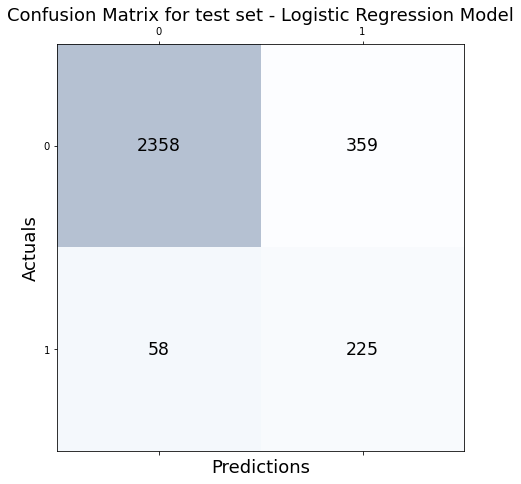

In [85]:
# Print the confusion matrix using Matplotlib
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(con_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(con_matrix.shape[0]):
    for j in range(con_matrix.shape[1]):
        ax.text(x=i, y=j,s=con_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for test set - Logistic Regression Model', fontsize=18)
plt.show()

### 4.2.5  ROC AUC score on test data

The roc_auc score is: 0.6806336750430917


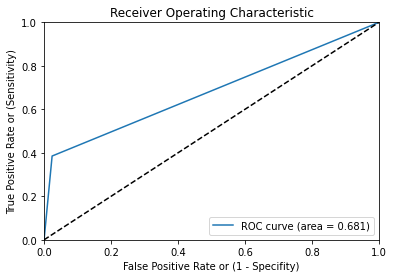

In [86]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(y_test, predicted)
roc_auc = auc(fpr, tpr)
gini_coefficient = (2*roc_auc)-1

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

print('The roc_auc score is:', roc_auc)

In the data above, the **training set accuracy** is **84.96%** and **test accuracy** is **86.10%**. If we look at the **Confusion Matrix**, **TPR** is **0.39** and **TNR** is **0.98**. The **roc_auc score** is **0.68**. Moreover, the training data is **highly imbalanced** and has more number of observations belonging to **"non-exited"** members as mentioned earlier. Therefore, we do oversampling using SMOTE package to over sample the minority class i.e. customers who has Exited in this case.

### 4.3.0  CLASS BALANCING APPROACH using SMOTE package : Over Sampling the Exited Set of customers data 

In [87]:
sm = SMOTE(random_state = 2)
X_train1,y_train1 = sm.fit_resample(X_train,y_train)

In [88]:
#len(y_train1)

In [89]:
#len(y_train)

Comparing the distribution of records in Target variable column between Exited and Non-exited individuals in **inbalanced Vs balanced** dataset

In [90]:
print('In imbalanced training data the distribution of non exited customers to exited customers is as follows:')
pd.Series(y_train['Exited']).value_counts()

In imbalanced training data the distribution of non exited customers to exited customers is as follows:


0    5547
1    1453
Name: Exited, dtype: int64

In [91]:
print('In balanced training data the distribution of non exited customers to exited customers is as follows:')
pd.Series(y_train1['Exited']).value_counts()

In balanced training data the distribution of non exited customers to exited customers is as follows:


1    5547
0    5547
Name: Exited, dtype: int64

### 4.3.1  Re development of Model after class balancing

In [92]:
classifier = lor()
model = classifier.fit(X_train1,y_train1)

### 4.3.2  K- Fold Cross Validation Data Performance

In [93]:
from sklearn.model_selection import cross_val_score,KFold
kf=KFold(n_splits=10)
score=cross_val_score(model,X_train1,y_train1,scoring='accuracy',cv=kf)
#print("Cross Validation Scores are {}".format(score))

#print('Accuracy on train set containing balanced data : {:.2f}%'.format(classifier.score(X_train1, y_train1)*100))
print("Average Cross Validation accuracy is :{:.2f}%".format(score.mean()*100))

Average Cross Validation accuracy is :73.75%


### 4.3.3  Model Performance on Test Data using Logistic Regression

In [94]:
predictions = classifier.predict(X_test)
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)

print('Accuracy on train set containing balanced data : {:.2f}%'.format(classifier.score(X_train1, y_train1)*100))
print("Accuracy on test set : %.2f%%" % (accuracy * 100.0))

Accuracy on train set containing balanced data : 75.31%
Accuracy on test set : 76.67%


In [95]:
# actual values
actual = y_test.values.tolist()
# predicted values
predicted = predictions.tolist()

# confusion matrix
con_matrix = confusion_matrix(actual,predicted, labels=[0,1])
print('Confusion matrix : \n',con_matrix)

# outcome values order in sklearn
tp, fn, fp, tn = confusion_matrix(actual,predicted,labels=[1,0]).reshape(-1)
print("\nTPR or Sensitivity or Recall is {:.2f}".format(tp/(tp+fn)),"\nPrecision is {:.2f}".format(tp/(tp+fp)), "\nFNR is {:.2f}".format(fn/(fn+tp)),"\nFPR or (1-Specificity) is {:.2f}".format(fp/(fp+tn)),"\nTNR is {:.2f}".format(tn/(tn+fp),"\nPrecision is {:.2f}".format(tp/(tp+fp))))


# classification report for precision, recall f1-score and accuracy
matrix = classification_report(actual,predicted,labels=[1,0])
print('\nClassification report : \n',matrix)

Confusion matrix : 
 [[1848  568]
 [ 132  452]]

TPR or Sensitivity or Recall is 0.77 
Precision is 0.44 
FNR is 0.23 
FPR or (1-Specificity) is 0.24 
TNR is 0.76

Classification report : 
               precision    recall  f1-score   support

           1       0.44      0.77      0.56       584
           0       0.93      0.76      0.84      2416

    accuracy                           0.77      3000
   macro avg       0.69      0.77      0.70      3000
weighted avg       0.84      0.77      0.79      3000



### 4.3.4  Confusion Matrix Plot for Logistic Regression Model

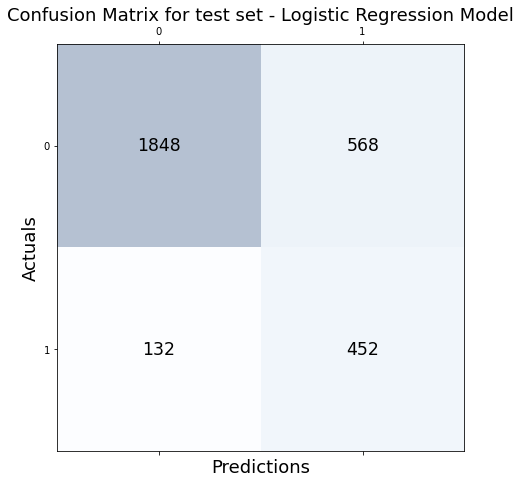

In [96]:
# Print the confusion matrix using Matplotlib

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(con_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(con_matrix.shape[0]):
    for j in range(con_matrix.shape[1]):
        ax.text(x=j, y=i,s=con_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for test set - Logistic Regression Model', fontsize=18)
plt.show()

### 4.3.5  ROC AUC score on test data

The roc_auc score is: 0.7694366324956908


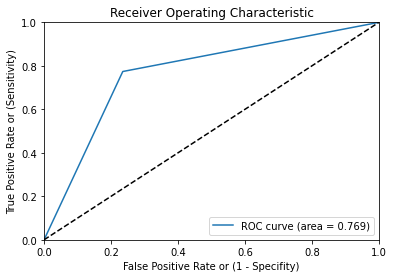

In [97]:
# Compute fpr, tpr, thresholds and roc auc

fpr, tpr, thresholds = roc_curve(y_test, predicted)
roc_auc = auc(fpr, tpr)
gini_coefficient = (2*roc_auc)-1

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")


print('The roc_auc score is:', roc_auc)

In [98]:
#Weight	Feature
#0.0556 ± 0.0143	Num_Prods_2
#0.0284 ± 0.0035	age_greater_48
#0.0269 ± 0.0038	IsActiveMember
#0.0146 ± 0.0040	Geography_East
#0.0144 ± 0.0042	age_30_34
#0.0119 ± 0.0011	Num_Prods_3

## 4.4 CATBOOST MODEL

### 4.4.1 Hyper Parameter Tuning using GridSearchCV

#### Model development on TRAIN Data - Applying GRIDSEARCH CROSS VALIDATION Method to come up with optimal value of hyper parameters (combination for which Accuracy is maximum)

In [99]:
model_tune = CatBoostClassifier()

parameters = {'learning_rate': np.arange(0.02,0.1,0.01),
       'depth': [3,4,6,8,10],
       'l2_leaf_reg': [1,3,5,7,9]}

grid = GridSearchCV(estimator=model_tune,param_grid = parameters,cv=2,n_jobs=-1)

grid.fit(X_train1,y_train1)

0:	learn: 0.6860298	total: 143ms	remaining: 2m 22s
1:	learn: 0.6786955	total: 150ms	remaining: 1m 15s
2:	learn: 0.6725850	total: 156ms	remaining: 51.9s
3:	learn: 0.6658832	total: 164ms	remaining: 40.8s
4:	learn: 0.6590076	total: 170ms	remaining: 33.8s
5:	learn: 0.6529151	total: 177ms	remaining: 29.3s
6:	learn: 0.6466308	total: 182ms	remaining: 25.9s
7:	learn: 0.6406496	total: 189ms	remaining: 23.4s
8:	learn: 0.6353704	total: 195ms	remaining: 21.4s
9:	learn: 0.6299225	total: 201ms	remaining: 19.9s
10:	learn: 0.6247411	total: 207ms	remaining: 18.6s
11:	learn: 0.6198132	total: 213ms	remaining: 17.6s
12:	learn: 0.6151253	total: 219ms	remaining: 16.6s
13:	learn: 0.6111339	total: 225ms	remaining: 15.9s
14:	learn: 0.6068380	total: 232ms	remaining: 15.2s
15:	learn: 0.6033200	total: 237ms	remaining: 14.5s
16:	learn: 0.6001956	total: 242ms	remaining: 14s
17:	learn: 0.5971376	total: 248ms	remaining: 13.5s
18:	learn: 0.5938572	total: 253ms	remaining: 13.1s
19:	learn: 0.5910882	total: 260ms	remaini

179:	learn: 0.4882906	total: 866ms	remaining: 3.94s
180:	learn: 0.4881631	total: 870ms	remaining: 3.94s
181:	learn: 0.4880877	total: 873ms	remaining: 3.92s
182:	learn: 0.4880226	total: 876ms	remaining: 3.91s
183:	learn: 0.4879385	total: 880ms	remaining: 3.9s
184:	learn: 0.4878663	total: 884ms	remaining: 3.89s
185:	learn: 0.4878158	total: 887ms	remaining: 3.88s
186:	learn: 0.4877572	total: 891ms	remaining: 3.87s
187:	learn: 0.4876554	total: 894ms	remaining: 3.86s
188:	learn: 0.4876347	total: 897ms	remaining: 3.85s
189:	learn: 0.4875556	total: 901ms	remaining: 3.84s
190:	learn: 0.4874806	total: 903ms	remaining: 3.83s
191:	learn: 0.4873732	total: 906ms	remaining: 3.81s
192:	learn: 0.4873170	total: 909ms	remaining: 3.8s
193:	learn: 0.4872816	total: 912ms	remaining: 3.79s
194:	learn: 0.4872226	total: 915ms	remaining: 3.78s
195:	learn: 0.4871329	total: 918ms	remaining: 3.77s
196:	learn: 0.4870988	total: 922ms	remaining: 3.76s
197:	learn: 0.4870465	total: 926ms	remaining: 3.75s
198:	learn: 0.

350:	learn: 0.4831687	total: 1.39s	remaining: 2.57s
351:	learn: 0.4831667	total: 1.39s	remaining: 2.56s
352:	learn: 0.4831611	total: 1.39s	remaining: 2.55s
353:	learn: 0.4831547	total: 1.4s	remaining: 2.55s
354:	learn: 0.4831360	total: 1.4s	remaining: 2.54s
355:	learn: 0.4830964	total: 1.4s	remaining: 2.54s
356:	learn: 0.4830915	total: 1.41s	remaining: 2.53s
357:	learn: 0.4830855	total: 1.41s	remaining: 2.53s
358:	learn: 0.4830619	total: 1.41s	remaining: 2.52s
359:	learn: 0.4830540	total: 1.41s	remaining: 2.52s
360:	learn: 0.4830484	total: 1.42s	remaining: 2.51s
361:	learn: 0.4830464	total: 1.42s	remaining: 2.5s
362:	learn: 0.4830289	total: 1.42s	remaining: 2.5s
363:	learn: 0.4830067	total: 1.43s	remaining: 2.49s
364:	learn: 0.4829809	total: 1.43s	remaining: 2.48s
365:	learn: 0.4829782	total: 1.43s	remaining: 2.48s
366:	learn: 0.4829742	total: 1.43s	remaining: 2.47s
367:	learn: 0.4829663	total: 1.44s	remaining: 2.47s
368:	learn: 0.4829528	total: 1.44s	remaining: 2.46s
369:	learn: 0.482

527:	learn: 0.4817294	total: 1.94s	remaining: 1.73s
528:	learn: 0.4817177	total: 1.94s	remaining: 1.73s
529:	learn: 0.4817163	total: 1.95s	remaining: 1.73s
530:	learn: 0.4817132	total: 1.95s	remaining: 1.72s
531:	learn: 0.4817116	total: 1.95s	remaining: 1.72s
532:	learn: 0.4817078	total: 1.96s	remaining: 1.71s
533:	learn: 0.4817072	total: 1.96s	remaining: 1.71s
534:	learn: 0.4816895	total: 1.96s	remaining: 1.71s
535:	learn: 0.4816893	total: 1.97s	remaining: 1.7s
536:	learn: 0.4816796	total: 1.97s	remaining: 1.7s
537:	learn: 0.4816787	total: 1.97s	remaining: 1.69s
538:	learn: 0.4816672	total: 1.97s	remaining: 1.69s
539:	learn: 0.4816649	total: 1.98s	remaining: 1.68s
540:	learn: 0.4816485	total: 1.98s	remaining: 1.68s
541:	learn: 0.4816328	total: 1.98s	remaining: 1.68s
542:	learn: 0.4816301	total: 1.99s	remaining: 1.67s
543:	learn: 0.4816264	total: 1.99s	remaining: 1.67s
544:	learn: 0.4816242	total: 1.99s	remaining: 1.66s
545:	learn: 0.4816094	total: 2s	remaining: 1.66s
546:	learn: 0.481

702:	learn: 0.4808142	total: 2.48s	remaining: 1.05s
703:	learn: 0.4808063	total: 2.48s	remaining: 1.04s
704:	learn: 0.4808003	total: 2.48s	remaining: 1.04s
705:	learn: 0.4807997	total: 2.48s	remaining: 1.03s
706:	learn: 0.4807959	total: 2.49s	remaining: 1.03s
707:	learn: 0.4807941	total: 2.49s	remaining: 1.03s
708:	learn: 0.4807873	total: 2.49s	remaining: 1.02s
709:	learn: 0.4807840	total: 2.49s	remaining: 1.02s
710:	learn: 0.4807836	total: 2.5s	remaining: 1.01s
711:	learn: 0.4807801	total: 2.5s	remaining: 1.01s
712:	learn: 0.4807746	total: 2.5s	remaining: 1.01s
713:	learn: 0.4807716	total: 2.5s	remaining: 1s
714:	learn: 0.4807682	total: 2.51s	remaining: 1s
715:	learn: 0.4807675	total: 2.51s	remaining: 996ms
716:	learn: 0.4807612	total: 2.51s	remaining: 992ms
717:	learn: 0.4807591	total: 2.52s	remaining: 989ms
718:	learn: 0.4807532	total: 2.52s	remaining: 985ms
719:	learn: 0.4807524	total: 2.52s	remaining: 981ms
720:	learn: 0.4807512	total: 2.53s	remaining: 978ms
721:	learn: 0.4807481	

887:	learn: 0.4803659	total: 3.02s	remaining: 382ms
888:	learn: 0.4803650	total: 3.03s	remaining: 378ms
889:	learn: 0.4803647	total: 3.03s	remaining: 375ms
890:	learn: 0.4803643	total: 3.03s	remaining: 371ms
891:	learn: 0.4803608	total: 3.04s	remaining: 368ms
892:	learn: 0.4803585	total: 3.04s	remaining: 364ms
893:	learn: 0.4803581	total: 3.04s	remaining: 361ms
894:	learn: 0.4803568	total: 3.04s	remaining: 357ms
895:	learn: 0.4803575	total: 3.05s	remaining: 354ms
896:	learn: 0.4803546	total: 3.05s	remaining: 350ms
897:	learn: 0.4803530	total: 3.05s	remaining: 347ms
898:	learn: 0.4803525	total: 3.05s	remaining: 343ms
899:	learn: 0.4803492	total: 3.06s	remaining: 340ms
900:	learn: 0.4803471	total: 3.06s	remaining: 336ms
901:	learn: 0.4803470	total: 3.06s	remaining: 333ms
902:	learn: 0.4803459	total: 3.06s	remaining: 329ms
903:	learn: 0.4803471	total: 3.07s	remaining: 326ms
904:	learn: 0.4803431	total: 3.07s	remaining: 322ms
905:	learn: 0.4803404	total: 3.07s	remaining: 319ms
906:	learn: 

GridSearchCV(cv=2,
             estimator=<catboost.core.CatBoostClassifier object at 0x0000020F34A3A160>,
             n_jobs=-1,
             param_grid={'depth': [3, 4, 6, 8, 10],
                         'l2_leaf_reg': [1, 3, 5, 7, 9],
                         'learning_rate': array([0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09])})

In [100]:
print('The optimal set of hyperparameters is :\n' ,grid.best_params_)

The optimal set of hyperparameters is :
 {'depth': 4, 'l2_leaf_reg': 1, 'learning_rate': 0.02}


In [101]:
print('The best accuracy score is :\n' ,grid.best_score_)

The best accuracy score is :
 0.7640165855417342


In [102]:
def plot_feature_importance(importance,names,model_type):
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data) 
    fi_df.sort_values(by=['feature_importance'],ascending=False,inplace=True)
    plt.figure(figsize=(10,8))
    sns.barplot(x=fi_df['feature_importance'],y=fi_df['feature_names'])
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

In [103]:
def get_categorical_indicies(X):
    cats = []
    for col in X.columns:
        #if is_numeric_dtype(X[col]):
        #    pass
        #else:
        cats.append(col)
    cat_indicies = []
    for col in cats:
        cat_indicies.append(X.columns.get_loc(col))
    return cat_indicies

In [104]:
categorical_indicies = get_categorical_indicies(X_train1)

In [105]:
#def convert_cats(X):
#    cats = []
#    for col in X.columns:
#        #if is_numeric_dtype(X[col]):
#        #    pass
#        #else:
#        cats.append(col)
#    cat_indicies = []
#    for col in cats:
#        X[col] = X[col].astype('str')

In [106]:
#def validate(model,val_data):
#    y = model.predict(val_data[0])
#    print('Accuracy = ', accuracy_score(y,val_data[1]))
#    print('roc_auc = ',roc_auc_score(y,val_data[1]))
#    print('F1 = ',f1_score(y,val_data[1]))
#    print('confusion_matrix = \n',confusion_matrix(y,val_data[1]))

### 4.4.2 -  Train the model with tuned hyper parameters

In [107]:
model_cb = CatBoostClassifier(depth = 4,l2_leaf_reg = 1, learning_rate = 0.02)
model_cb.fit(X_train1,y_train1,verbose=0,cat_features=categorical_indicies)

In [108]:
print('Accuracy on train set containing balanced data : {:.2f}%'.format(model_cb.score(X_train1, y_train1)*100))


Accuracy on train set containing balanced data : 76.42%


### 4.4.3 -  K-fold cross validation data performance

In [109]:
rfe = RFE(estimator=CatBoostClassifier(), n_features_to_select=9)
#Model Pipeline Catboost
pipeline = Pipeline(steps=[('s',rfe),('m',model_cb)])
# evaluate model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, X_train1, y_train1, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy on K Fold cross validation set : %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy on K Fold cross validation set : 0.760 (0.013)


### 4.4.4  Feature Importance of Catboost Model

**Catboost Feature Importance** is done by taking the **difference between the metric (for example, loss function)** obtained while building the model using this feature vs when it is not.Higher the difference the more important that feature is.

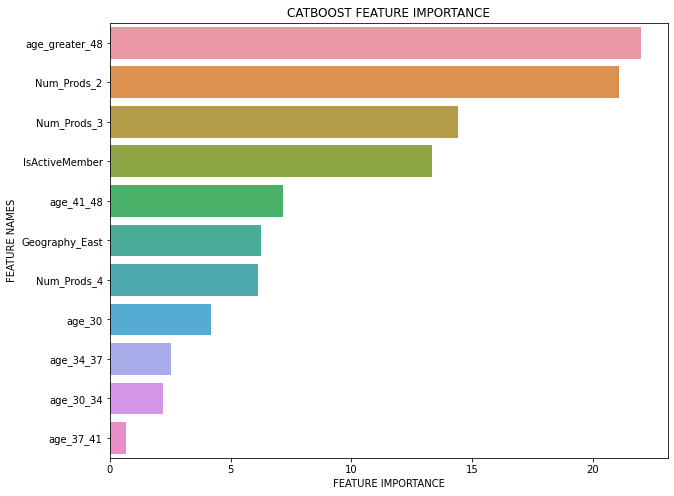

In [110]:
plot_feature_importance(model_cb.get_feature_importance(),X_train1.columns,'CATBOOST')

### 4.4.5 - Model Performance on Test Data using Catboost Model

In [111]:
pred = model_cb.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.93      0.79      0.85      2416
           1       0.46      0.74      0.57       584

    accuracy                           0.78      3000
   macro avg       0.69      0.76      0.71      3000
weighted avg       0.84      0.78      0.80      3000



### 4.4.6 - ROC AUC score on Test Data

The roc_auc score is: 0.7649942166379389


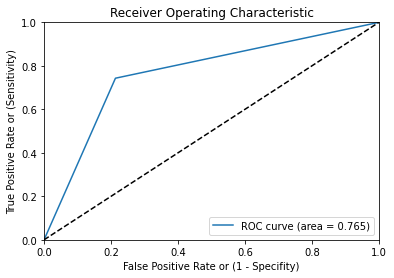

In [112]:
# Compute fpr, tpr, thresholds and roc auc

fpr, tpr, thresholds = roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)
gini_coefficient = (2*roc_auc)-1

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")


print('The roc_auc score is:', roc_auc)

### 4.4.7 - Confusion Matrix Plot for Catboost Model 

In [113]:
# confusion matrix in sklearn

# actual values
actual = y_test.values.tolist()
# predicted values
predicted = pred

# confusion matrix
con_matrix = confusion_matrix(actual,predicted, labels=[0,1])
print('Confusion matrix : \n',con_matrix)

# outcome values order in sklearn
tp, fn, fp, tn = confusion_matrix(actual,predicted,labels=[1,0]).reshape(-1)
print("\nTPR or Sensitivity or Recall is {:.2f}".format(tp/(tp+fn)),"\nPrecision is {:.2f}".format(tp/(tp+fp)), "\nFNR is {:.2f}".format(fn/(fn+tp)),"\nFPR or (1-Specificity) is {:.2f}".format(fp/(fp+tn)),"\nTNR is {:.2f}".format(tn/(tn+fp),"\nPrecision is {:.2f}".format(tp/(tp+fp))))


# classification report for precision, recall f1-score and accuracy
matrix = classification_report(actual,predicted,labels=[1,0])
print('\nClassification report : \n',matrix)

Confusion matrix : 
 [[1901  515]
 [ 150  434]]

TPR or Sensitivity or Recall is 0.74 
Precision is 0.46 
FNR is 0.26 
FPR or (1-Specificity) is 0.21 
TNR is 0.79

Classification report : 
               precision    recall  f1-score   support

           1       0.46      0.74      0.57       584
           0       0.93      0.79      0.85      2416

    accuracy                           0.78      3000
   macro avg       0.69      0.76      0.71      3000
weighted avg       0.84      0.78      0.80      3000



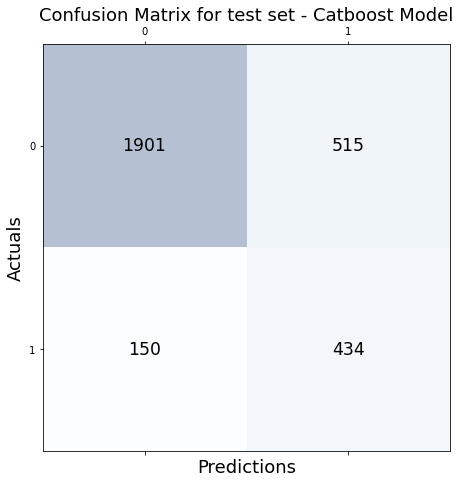

In [114]:
# Print the confusion matrix using Matplotlib

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(con_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(con_matrix.shape[0]):
    for j in range(con_matrix.shape[1]):
        ax.text(x=j, y=i,s=con_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for test set - Catboost Model', fontsize=18)
plt.show()

## 4.5 - Decision Tree Classifier Model

In [115]:
#model_dt = DecisionTreeClassifier()

#parameters = {"splitter":["best","random"],
#            "max_depth" : [1,3,5,7,9,11,12],
#           "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
#           "min_weight_fraction_leaf":[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
#           "max_features":["auto","log2","sqrt",None],
#           "max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90]}

#grid = GridSearchCV(estimator=model_dt,param_grid = parameters,cv=2,n_jobs=-1)

#grid.fit(X_train1,y_train1)

In [116]:
#grid.best_params_

In [117]:
#model_dt = DecisionTreeClassifier(max_depth = 12,max_features = 'auto',max_leaf_nodes = None,min_samples_leaf= 1,min_weight_fraction_leaf = 0.1,splitter ='random')

### 4.5.1 -  Train the model

In [118]:
model = DecisionTreeClassifier()
model_dc = model.fit(X_train1,y_train1)

In [119]:
print('Accuracy on train set containing balanced data : {:.2f}%'.format(model_dc.score(X_train1, y_train1)*100))


Accuracy on train set containing balanced data : 76.42%


### 4.5.2 - K Fold Cross Validation Data Performance

In [120]:
# Model pipeline Decision Trees
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=9)
pipeline = Pipeline(steps=[('s',rfe),('m',model_dc)])
# evaluate model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, X_train1, y_train1, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy on K Fold Cross Validation Set: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy on K Fold Cross Validation Set: 0.764 (0.012)


### 4.5.3 - Model Performance on Test Data using Decision Tree

In [121]:
predictions = model_dc.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.93      0.79      0.85      2416
           1       0.46      0.74      0.57       584

    accuracy                           0.78      3000
   macro avg       0.69      0.76      0.71      3000
weighted avg       0.84      0.78      0.80      3000



In [122]:
# confusion matrix in sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# actual values
actual = y_test.values.tolist()
# predicted values
predicted = predictions

# confusion matrix
con_matrix = confusion_matrix(actual,predicted, labels=[0,1])
print('Confusion matrix : \n',con_matrix)

# outcome values order in sklearn
tp, fn, fp, tn = confusion_matrix(actual,predicted,labels=[1,0]).reshape(-1)
print("\nTPR or Sensitivity or Recall is {:.2f}".format(tp/(tp+fn)),"\nPrecision is {:.2f}".format(tp/(tp+fp)), "\nFNR is {:.2f}".format(fn/(fn+tp)),"\nFPR or (1-Specificity) is {:.2f}".format(fp/(fp+tn)),"\nTNR is {:.2f}".format(tn/(tn+fp),"\nPrecision is {:.2f}".format(tp/(tp+fp))))

# classification report for precision, recall f1-score and accuracy
matrix = classification_report(actual,predicted,labels=[1,0])
print('Classification report : \n',matrix)

Confusion matrix : 
 [[1903  513]
 [ 151  433]]

TPR or Sensitivity or Recall is 0.74 
Precision is 0.46 
FNR is 0.26 
FPR or (1-Specificity) is 0.21 
TNR is 0.79
Classification report : 
               precision    recall  f1-score   support

           1       0.46      0.74      0.57       584
           0       0.93      0.79      0.85      2416

    accuracy                           0.78      3000
   macro avg       0.69      0.76      0.71      3000
weighted avg       0.84      0.78      0.80      3000



### 4.5.4 - Confusion Matrix Plot for Decision Tree Model

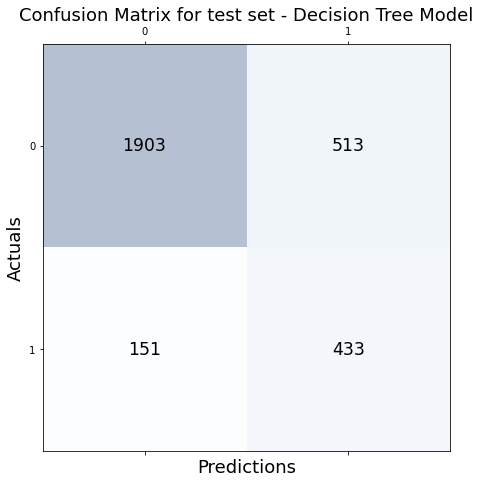

In [123]:
# Print the confusion matrix using Matplotlib

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(con_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(con_matrix.shape[0]):
    for j in range(con_matrix.shape[1]):
        ax.text(x=j, y=i,s=con_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for test set - Decision Tree Model', fontsize=18)
plt.show()

### 4.5.5 - ROC AUC Score on Test Data

The roc_auc score is: 0.7649942166379389


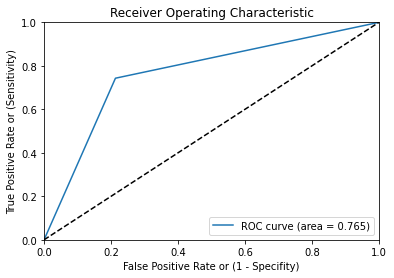

In [124]:
# Compute fpr, tpr, thresholds and roc auc

fpr, tpr, thresholds = roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)
gini_coefficient = (2*roc_auc)-1

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")


print('The roc_auc score is:', roc_auc)

### 4.6 -  EXTREME GRADIENT BOOSTING MODEL

In [125]:
#param_test1 = {
# 'n_estimators': range(45,60,5),
# 'max_depth': [5],
# 'min_child_weight' : [1],
# 'gamma': [0], #np.arange(0,0.3,0.1),
# 'subsample' : [0.5], #np.arange(0.4,1,0.1),
# 'colsample_bytree' :[0.9], #np.arange(0.5,0.9,0.1),
# 'eta' : np.arange(0.02,0.11,0.01)
#}
#gsearch1 = GridSearchCV(estimator = XGBClassifier(),param_grid = param_test1, scoring='accuracy',n_jobs=4, cv=5)

#grid_result = gsearch1.fit(X_train1, y_train1)
## summarize results
#print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
#means = grid_result.cv_results_['mean_test_score']
#stds = grid_result.cv_results_['std_test_score']
#params = grid_result.cv_results_['params']
#for mean, stdev, param in zip(means, stds, params):
#    print("%f (%f) with: %r" % (mean, stdev, param))



#gsearch1.fit(X_train1,y_train1)
#gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

#gsearch1.best_params_,  gsearch1.best_score_

In [126]:
#gsearch1.best_params_

### 4.6.1 - Train the Model

In [127]:
# fit model on training data
model_xgb = XGBClassifier(eta =0.02, #0.02 to 0.15
n_estimators=55, # 50 to 150
max_depth=5,    # 3 to 12
min_child_weight=1, # 0.5 to 1 
gamma=0.0, # 0 to 1
subsample=0.5, # 0.2 to 1
colsample_bytree=0.9, # 0.5 to 1
objective= 'binary:logistic',
nthread=4,
scale_pos_weight=1,
seed=27)


In [128]:
#gsearch1
model_xgb.fit(X_train1, y_train1)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.9,
              early_stopping_rounds=None, enable_categorical=False, eta=0.02,
              eval_metric=None, gamma=0.0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.0199999996, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=55, n_jobs=4,
              nthread=4, num_parallel_tree=1, predictor='auto', random_state=27, ...)

In [129]:
print('Accuracy on train set containing balanced data : {:.2f}%'.format(model_xgb.score(X_train1, y_train1)*100))

Accuracy on train set containing balanced data : 76.34%


### 4.6.2 - K Fold Cross Validation Data Performance

In [130]:
rfe = RFE(estimator=XGBClassifier(), n_features_to_select=9)
#model = DecisionTreeClassifier()
pipeline = Pipeline(steps=[('s',rfe),('m',model_xgb)])
# evaluate model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, X_train1, y_train1, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy on cross validation data: %.3f (%.3f)' , (np.mean(n_scores)))

Accuracy on cross validation data: %.3f (%.3f) 0.7593887034013272


In [131]:
np.mean(n_scores)

0.7593887034013272

### 4.6.3 -  Model Performance on Test Data using Extreme Gradient Boosting

#### Accuracy Check on Test dataset

In [132]:
# make predictions for test data
y_pred = model_xgb.predict(X_test)
predictions = [round(value) for value in y_pred]

In [133]:
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 77.70%


### 4.6.4 - ROC AUC Score on Test Data

The roc_auc score is: 0.7622187698448697 
The gini value is: 0.5244375396897394


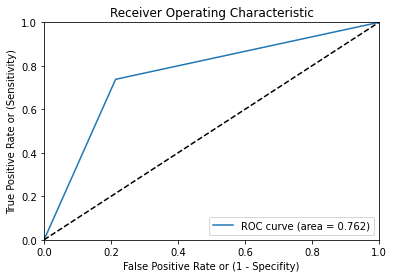

In [134]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)
gini_coefficient = (2*roc_auc)-1

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

print('The roc_auc score is:', roc_auc,'\nThe gini value is:', gini_coefficient)

### 4.6.5 - Confusion Matrix Plot for XGB Model

In [135]:
# confusion matrix in sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# actual values
actual = y_test.values.tolist()
# predicted values
predicted = predictions

# confusion matrix
con_matrix = confusion_matrix(actual,predicted, labels=[0,1])
print('Confusion matrix : \n',con_matrix)

# outcome values order in sklearn
tp, fn, fp, tn = confusion_matrix(actual,predicted,labels=[1,0]).reshape(-1)
print("\nTPR or Sensitivity or Recall is {:.2f}".format(tp/(tp+fn)),"\nPrecision is {:.2f}".format(tp/(tp+fp)), "\nFNR is {:.2f}".format(fn/(fn+tp)),"\nFPR or (1-Specificity) is {:.2f}".format(fp/(fp+tn)),"\nTNR is {:.2f}".format(tn/(tn+fp),"\nPrecision is {:.2f}".format(tp/(tp+fp))))


# classification report for precision, recall f1-score and accuracy
matrix = classification_report(actual,predicted,labels=[1,0])
print('\nClassification report : \n',matrix)

Confusion matrix : 
 [[1900  516]
 [ 153  431]]

TPR or Sensitivity or Recall is 0.74 
Precision is 0.46 
FNR is 0.26 
FPR or (1-Specificity) is 0.21 
TNR is 0.79

Classification report : 
               precision    recall  f1-score   support

           1       0.46      0.74      0.56       584
           0       0.93      0.79      0.85      2416

    accuracy                           0.78      3000
   macro avg       0.69      0.76      0.71      3000
weighted avg       0.83      0.78      0.79      3000



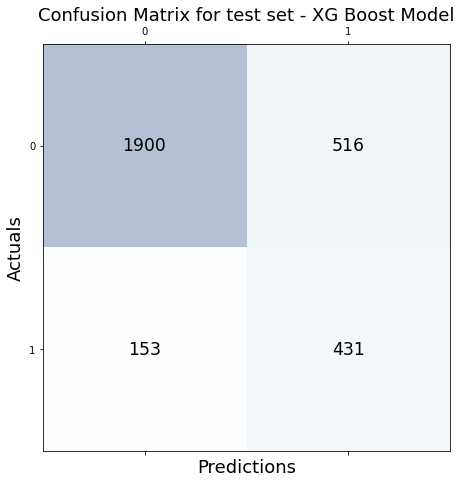

In [136]:
# Print the confusion matrix using Matplotlib
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(con_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(con_matrix.shape[0]):
    for j in range(con_matrix.shape[1]):
        ax.text(x=j, y=i,s=con_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for test set - XG Boost Model', fontsize=18)
plt.show()

# End of Model Implementation Activity

In [137]:
#### Extreme Gradient Boosting Model Implementation

In [138]:
#param_test1 = {
# 'n_estimators': range(45,60,5),
# 'max_depth': range(3,7,2),
# 'min_child_weight' : [1],
# 'gamma': 0.0,
# 'subsample' : np.arange(0.2,0.7,0.1),
# 'colsample_bytree' : np.arange(0.3,0.6,0.1),
# 'eta' : np.arange(0.05,0.11,0.01)
#}
#gsearch1 = GridSearchCV(estimator = XGBClassifier( eta = 0.1, n_estimators=55, max_depth=3,
#min_child_weight=1, gamma=0.5, subsample=0.3, colsample_bytree=0.6,
#objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
#param_grid = param_test1, scoring='accuracy',n_jobs=4, cv=5)

#grid_result = gsearch1.fit(X_train1, y_train1)
## summarize results
#print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
#means = grid_result.cv_results_['mean_test_score']
#stds = grid_result.cv_results_['std_test_score']
#params = grid_result.cv_results_['params']
#for mean, stdev, param in zip(means, stds, params):
#    print("%f (%f) with: %r" % (mean, stdev, param))

In [139]:
# fit model no training data
#model_xgb = XGBClassifier(learning_rate =0.02, #0.02 to 0.15
#n_estimators=50, # 50 to 550
#max_depth=5,    # 3 to 12
#min_child_weight=1, # 0.5 to 1 
#gamma=0.0, # 0 to 1
#subsample=0.5, # 0.2 to 1
#colsample_bytree=0.9, # 0.5 to 1
#objective= 'binary:logistic',
#nthread=4,
#scale_pos_weight=1,
#seed=27)

In [140]:
#gsearch1
#model_xgb.fit(X_train1, y_train1)

In [141]:
## evaluate predictions
#accuracy = accuracy_score(y_test, predictions)
#print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [142]:
#from sklearn.metrics import roc_curve
#from sklearn.metrics import auc

## Compute fpr, tpr, thresholds and roc auc
#fpr, tpr, thresholds = roc_curve(y_test, predictions)
#roc_auc = auc(fpr, tpr)
#gini_coefficient = (2*roc_auc)-1

## Plot ROC curve
#plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
#plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
#plt.xlim([0.0, 1.0])
#plt.ylim([0.0, 1.0])
#plt.xlabel('False Positive Rate or (1 - Specifity)')
#plt.ylabel('True Positive Rate or (Sensitivity)')
#plt.title('Receiver Operating Characteristic')
#plt.legend(loc="lower right")

#print('The roc_auc score is:', roc_auc,'\nThe gini value is:', gini_coefficient)

In [143]:
# confusion matrix in sklearn
#from sklearn.metrics import confusion_matrix
#from sklearn.metrics import classification_report

## actual values
#actual = y_test.values.tolist()
## predicted values
#predicted = predictions

## confusion matrix
#con_matrix = confusion_matrix(actual,predicted, labels=[1,0])
#print('Confusion matrix : \n',con_matrix)

# outcome values order in sklearn
#tp, fn, fp, tn = confusion_matrix(actual,predicted,labels=[1,0]).reshape(-1)
#print("\nTPR or Sensitivity or Recall is {:.2f}".format(tp/(tp+fn)),"\nPrecision is {:.2f}".format(tp/(tp+fp)), "\nFNR is {:.2f}".format(fn/(fn+tp)),"\nFPR or (1-Specificity) is {:.2f}".format(fp/(fp+tn)),"\nTNR is {:.2f}".format(tn/(tn+fp),"\nPrecision is {:.2f}".format(tp/(tp+fp))))


# classification report for precision, recall f1-score and accuracy
#matrix = classification_report(actual,predicted,labels=[1,0])
#print('\nClassification report : \n',matrix)

In [144]:
## Print the confusion matrix using Matplotlib
#import matplotlib.pyplot as plt

#fig, ax = plt.subplots(figsize=(7.5, 7.5))
#ax.matshow(con_matrix, cmap=plt.cm.Blues, alpha=0.3)
#for i in range(con_matrix.shape[0]):
#    for j in range(con_matrix.shape[1]):
#        ax.text(x=j, y=i,s=con_matrix[i, j], va='center', ha='center', size='xx-large')
 
#plt.xlabel('Predictions', fontsize=18)
#plt.ylabel('Actuals', fontsize=18)
#plt.title('Confusion Matrix for test set - Logistic Regression Model', fontsize=18)
#plt.show()

In [145]:
#from sklearn.model_selection import cross_val_score,KFold
#from sklearn.linear_model import LogisticRegression
#iris=load_iris()
#X=iris.data
#Y=iris.target
#logreg=LogisticRegression()
#kf=KFold(n_splits=10)
#score=cross_val_score(model_xgb,X_train1,y_train1,cv=kf)
#print("Cross Validation Scores are {}".format(score))
#print("Average Cross Validation score :{}".format(score.mean()))

######################### The End #################################################

###################################################################################

###################################################################################

###################################################################################

###################################################################################